In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D, Concatenate
import numpy as np

In [2]:
class UNet:
    def __init__(self, input_shape = (256, 256, 1), filters = [112,224,448,896], padding = "same"):
        """
        Unet model based on https://github.com/silburt/DeepMoon
        :param input_shape: input size should be 256x256x1
        :param filters:  each layers’ number of filters [112, 224, ..]
        :param padding: same
        """
        self.input_shape = input_shape
        self.filters = filters
        self.padding = padding

    def build_model(self):
        """
        :return: unet model
        """

        input = Input(self.input_shape)

        # the contracting block
        conv1, pool1 = self.contracting_block(input_layer = input, filters = self.filters[0], padding = self.padding)
        conv2, pool2 = self.contracting_block(input_layer = pool1, filters = self.filters[1], padding = self.padding)
        conv3, pool3 = self.contracting_block(input_layer = pool2, filters = self.filters[2], padding = self.padding)

        # bottleneck block
        bottleNeck = self.bottleneck_block(pool3, filters = self.filters[3], padding = self.padding)

        # the expansive block.
        upConv1 = self.expansive_block(bottleNeck, conv3, filters = self.filters[2], padding = self.padding)
        upConv2 = self.expansive_block(upConv1, conv2, filters = self.filters[1], padding = self.padding)
        upConv3 = self.expansive_block(upConv2, conv1, filters = self.filters[0], padding = self.padding)

        # output block
        output = Conv2D(1, (1, 1), padding = self.padding, activation = tf.math.sigmoid)(upConv3)

        model = Model(input, output, name = "UNet")

        return model

    def contracting_block(self, input_layer, filters, padding, kernel_size = 3):

        conv = Conv2D(filters = filters,
                      kernel_size = kernel_size,
                      activation = tf.nn.relu,
                      padding = padding)(input_layer)

        conv = Conv2D(filters = filters,
                      kernel_size = kernel_size,
                      activation = tf.nn.relu,
                      padding = padding)(conv)

        pool = MaxPooling2D(pool_size = 2,
                            strides = 2)(conv)

        return conv, pool

    def expansive_block(self, input_layer, connect_layer, filters, padding, kernel_size = 3):
        transConv = Conv2DTranspose(filters = filters,
                                    kernel_size = (2, 2),
                                    strides = 2,
                                    padding = padding)(input_layer)


        concat = Concatenate()([transConv, connect_layer])

        up_conv = Conv2D(filters = filters,
                         kernel_size = kernel_size,
                         padding = padding,
                         activation = tf.nn.relu)(concat)

        up_conv = Conv2D(filters = filters,
                         kernel_size = kernel_size,
                         padding = padding,
                         activation = tf.nn.relu)(up_conv)

        return up_conv


    def bottleneck_block(self, input_layer, filters, padding, kernel_size = 3, strides = 1):

        conv = Conv2D(filters = filters,
                      kernel_size = kernel_size,
                      padding = padding,
                      strides = strides,
                      activation = tf.nn.relu)(input_layer)

        conv = Conv2D(filters = filters,
                      kernel_size = kernel_size,
                      padding = padding,
                      strides = strides,
                      activation = tf.nn.relu)(conv)

        return conv





# Test input

In [3]:
 input_layer = array = np.random.random((256, 256, 1))

In [4]:
unet = UNet(input_shape = input_layer.shape,
            filters = [112,224,448,896] ,
            padding = "same")


In [5]:
model = unet.build_model()

In [6]:
model.compile()
print(model.summary())

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 11  1120        ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 11  113008      ['conv2d[0][0]']                 
                                2)                                                             

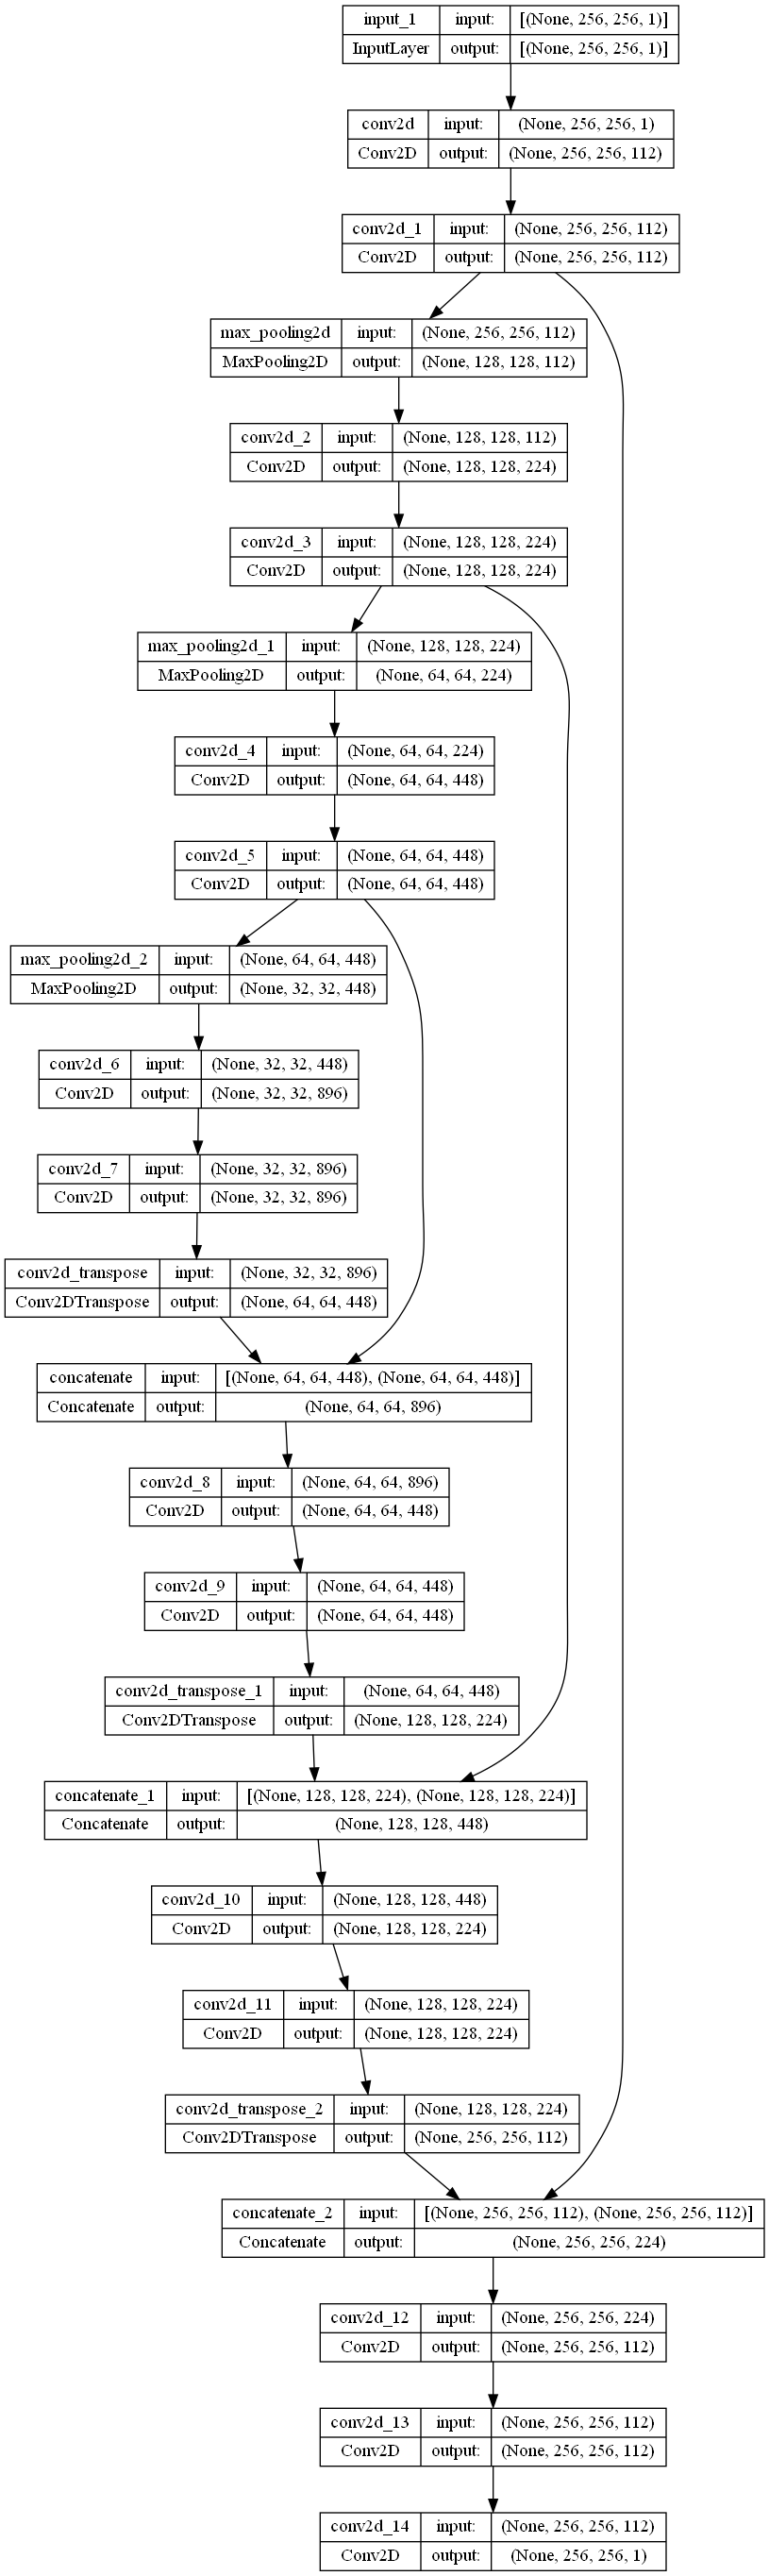

In [7]:
from IPython.display import Image
img_file = './model_arch.png'
tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)
Image(img_file)